In [1]:
import os

import rioxarray as rxr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from skimage.feature import peak_local_max
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd


from crea_graphics.colors import goodbad_cont

In [2]:
# where to write results
output_dir = "../data/result/analysis/"

os.makedirs(output_dir, exist_ok=True)

In [3]:
## Read data

# Total PM2.5 
da_total = rxr.open_rasterio("../data/result/merra/surf_aerosol_massconc/Total_PM25_2024.tif").squeeze()

# Sulfate aerosol
da_sulfate = rxr.open_rasterio("../data/result/merra/surf_aerosol_massconc/Sulfate_aerosol_2024.tif").squeeze()

# Sulfate aerosol fraction (%)
da_fraction = rxr.open_rasterio("../data/result/merra/surf_aerosol_fractions/Sulfate_fraction_2024.tif").squeeze()


# collect to one dataset
ds = xr.Dataset({
    "total": da_total,
    "sulfate": da_sulfate,
    "fraction": da_fraction
})


## 3a) Top 10 Hotspots of ammonium sulfate and its vicinity to power plant
Figure: Indian Map of ammonium sulfate concentration with highlighting top 10 hotspots and all power plant location

In [4]:
# read power plant data
df_tpp = pd.read_csv("../data/aux/India Power Plants and NCAP Cities Location - Thermal Power Plants Location_20250620.csv")
# convert to GeoDataFrame
df_tpp = gpd.GeoDataFrame(df_tpp, geometry=gpd.points_from_xy(df_tpp["Longitude"], df_tpp["Latitude"]), crs="EPSG:4326")

/home/work/Documents/projects/202505_india_secondary_aerosol/202505_india_secondary_aerosol/.venv/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


Text(0.5, 1.0, 'TPPs')

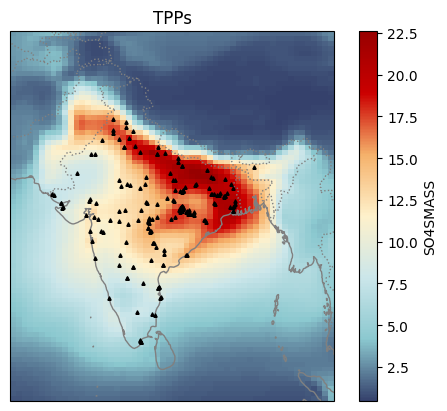

In [5]:
# create cartory figure
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

# plot the data on the map axis
ds.sulfate.plot(ax=ax, cmap=goodbad_cont, zorder=0)

# plot TPP as black triangles
df_tpp.plot(ax=ax, marker='^', color='black', markersize=5, label='Thermal Power Plants', zorder=3)

# add coastlines and country borders
ax.add_feature(cfeature.COASTLINE, color='gray', zorder=2)
ax.add_feature(cfeature.BORDERS, linestyle=':', color='gray', zorder=1)

plt.title('TPPs')

In [6]:
# find local maxima in the data

# find local maxima
coord_ix = peak_local_max(ds.sulfate.values)

# find x and y values for given coordinates
coord_x = ds.sulfate.coords['x'].values[coord_ix[:, 1]]
coord_y = ds.sulfate.coords['y'].values[coord_ix[:, 0]]

Text(0.5, 1.0, 'Local maxima')

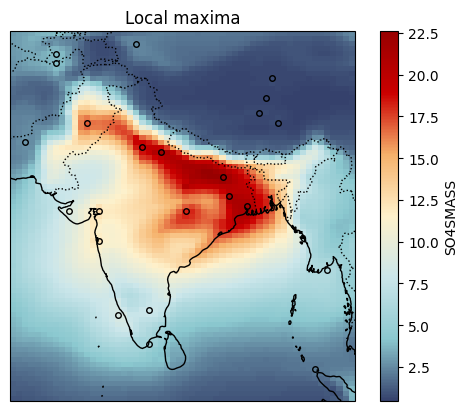

In [7]:
# create cartory figure
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

# plot the data on the map axis
ds.sulfate.plot(ax=ax, cmap=goodbad_cont)

# add coordinates as black circles
for coord in zip(coord_x, coord_y):
    ax.plot(coord[0], coord[1], 'ko', markersize=4, 
            markerfacecolor='none', markeredgecolor='black', 
            transform=ccrs.PlateCarree())

# add coastlines and country borders
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

plt.title('Local maxima')

## 3b) Contribution of ammonium sulfate to PM2.5 in 10 Km radius from all TPPS

Table: Power plant wise PM2.5, ammonium sulfate concentration and its contribution % to PM2.5

In [8]:
# get a polygon at 10km radius around each point
# use UTM projections 

def buffer_using_utm(gdf, identifier, buffer_distance=10e3):

    gdf['UTM_Zone'] = gdf.apply(lambda row: get_utm_epsg(row['Latitude'], row['Longitude']), axis=1)

    # check that SNo a unique identifier
    if gdf[identifier].nunique() != len(gdf):
        raise ValueError(f"Identifier '{identifier}' is not unique in the DataFrame.")

    # group by UTM zone, project, buffer, and project back to WGS84
    def buffer_and_project(gf, buffer_distance=buffer_distance):
        gf = gf.to_crs(epsg=gf['UTM_Zone'].iloc[0])  # Project to UTM zone
        gf['geometry'] = gf.geometry.buffer(buffer_distance)  # Buffer by 10 km
        return gf.to_crs(epsg=4326)  # Project back to WGS84

    gdf_buffered = gdf.groupby('UTM_Zone')[['geometry', 'UTM_Zone', identifier]].apply(buffer_and_project)

    # add new geometries to df_tpp, merging on Sno
    gdf_buffered = gdf.drop(columns='geometry').merge(gdf_buffered[['geometry', identifier]], on=identifier)
    # make to geodataframe
    gdf_buffered = gpd.GeoDataFrame(gdf_buffered, geometry='geometry', crs="EPSG:4326")

    return gdf_buffered

# for each point, find the UTM zone and corresponding EPSG code
def get_utm_epsg(lat, lon):
    zone_number = int((lon + 180) / 6) + 1
    if lat >= 0:
        epsg_code = 32600 + zone_number  # Northern Hemisphere
    else:
        epsg_code = 32700 + zone_number  # Southern Hemisphere
    return epsg_code


In [9]:
# buffer the TPPs
df_tpp_buffered = buffer_using_utm(df_tpp, identifier='SNo', buffer_distance=10e3)

In [10]:
# resolution of the MERRA2 data is around 50 km
# to meaningfully sample for an area with 10 km radius, upsample the data
# - not sure if really needed, but better safe than sorry

def upsample_satdata(data_in, factor):

    new_x = upsample_coords(data_in.coords['x'], factor)
    new_y = upsample_coords(data_in.coords['y'], factor)

    data_out = data_in.interp(
        x=new_x, y=new_y, method='nearest')

    return data_out

def upsample_coords(coord, factor):
    new_length = (len(coord) - 1) * factor + 1
    return xr.DataArray(
        data=np.linspace(coord.min().values, coord.max().values, new_length),
        dims=coord.dims,
        attrs=coord.attrs
    )


ds_fine = upsample_satdata(ds, factor=20)

In [11]:
# ## check upsampling

# # create cartory figure
# fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

# # plot the data on the map axis
# ds_fine.sulfate.plot(ax=ax, cmap=goodbad_cont)

# # add coastlines and country borders
# ax.add_feature(cfeature.COASTLINE)
# ax.add_feature(cfeature.BORDERS, linestyle=':')


In [12]:
# calculate mean sulfate concentration within each buffered area
for i, row in df_tpp_buffered.iterrows():
    buffered_area = row['geometry']
    clip = ds_fine.rio.clip([buffered_area])
    df_tpp_buffered.at[i, 'mean_ammonium_sulfate_ug/m3'] = clip.sulfate.mean().item() 
    df_tpp_buffered.at[i, 'mean_pm2.5_ug/m3'] = clip.total.mean().item()

# calculate the fraction of sulfate in PM2.5
df_tpp_buffered['sulfate_fraction_%'] = df_tpp_buffered['mean_ammonium_sulfate_ug/m3'] / df_tpp_buffered['mean_pm2.5_ug/m3'] * 100

In [13]:
# write data to csv

# first sort by SNo
df_tpp_buffered = df_tpp_buffered.sort_values(by='SNo')

df_out = df_tpp_buffered[['SNo', 'Power Plant Name', 'mean_ammonium_sulfate_ug/m3', 'mean_pm2.5_ug/m3', 'sulfate_fraction_%']]

df_out.to_csv(os.path.join(output_dir, '3b_plantwise_mean.csv'), index=False)

Plot data to check if results reasonable and get a first glance.

In [14]:
# make the polygons larger to see something
df_plot = df_tpp_buffered.copy()
# project to web mercator
df_plot = df_plot.to_crs(epsg=3857)
# buffer with 30 km
df_plot['geometry'] = df_plot.geometry.buffer(30e3)
# project back to WGS84
df_plot = df_plot.to_crs(epsg=4326)

/home/work/Documents/projects/202505_india_secondary_aerosol/202505_india_secondary_aerosol/.venv/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


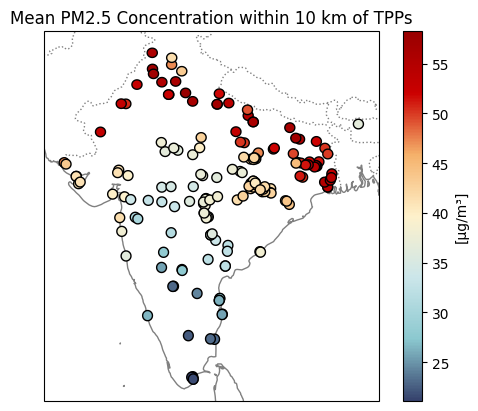

In [15]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(cfeature.BORDERS, linestyle=':', color='gray', zorder=0)
ax.add_feature(cfeature.COASTLINE, color='gray', zorder=1)

# da_total.plot(ax=ax, vmin=20, vmax=58, cmap=goodbad_cont)
# plt.scatter(df_tpp_buffered.geometry.centroid.x, df_tpp_buffered.geometry.centroid.y, 
#             c=df_tpp_buffered['mean_ammonium_sulfate_ug/m3'], 
#             cmap=goodbad_cont, s=30, edgecolor='black', zorder=2,
#             )


p = df_plot.plot(column='mean_pm2.5_ug/m3', cmap=goodbad_cont, legend=True, markersize=10,
                     legend_kwds={'label': '[µg/m³]'}, ax=ax, edgecolor='black',
                    #   vmin=20, vmax=58,
                     ).set_title('Mean PM2.5 Concentration within 10 km of TPPs')


/home/work/Documents/projects/202505_india_secondary_aerosol/202505_india_secondary_aerosol/.venv/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


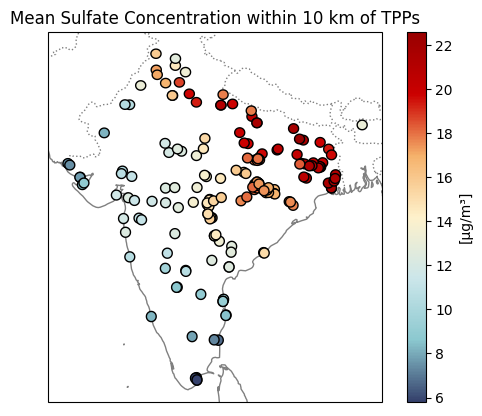

In [16]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(cfeature.BORDERS, linestyle=':', color='gray', zorder=0)
ax.add_feature(cfeature.COASTLINE, color='gray', zorder=1)

# da_sulfate.plot(ax=ax, vmin=6, vmax=22, cmap=goodbad_cont)

p = df_plot.plot(column='mean_ammonium_sulfate_ug/m3', cmap=goodbad_cont, legend=True, markersize=2,
                     legend_kwds={'label': '[µg/m³]'}, ax=ax, edgecolor='black',
                    #  vmin=6, vmax=22,
                     ).set_title('Mean Sulfate Concentration within 10 km of TPPs')


/home/work/Documents/projects/202505_india_secondary_aerosol/202505_india_secondary_aerosol/.venv/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


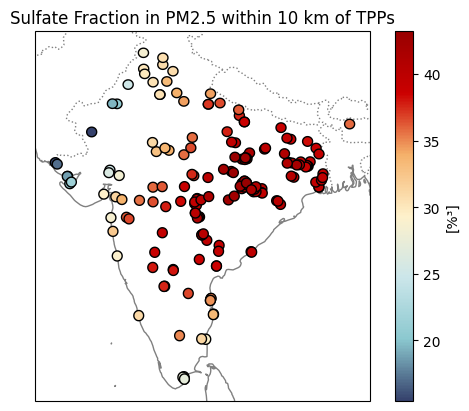

In [17]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(cfeature.BORDERS, linestyle=':', color='gray', zorder=0)
ax.add_feature(cfeature.COASTLINE, color='gray', zorder=1)

# da_fraction.plot(ax=ax, vmin=10, vmax=45, cmap=goodbad_cont)

p = df_plot.plot(column='sulfate_fraction_%', cmap=goodbad_cont, legend=True, markersize=2,
                     legend_kwds={'label': '[%³]'}, ax=ax, edgecolor='black',
                    #  vmin=10, vmax=45, 
                     ).set_title('Sulfate Fraction in PM2.5 within 10 km of TPPs')


## 3c) Contribution of ammonium sulfate to PM2.5 in no TPP regions (No)
Table: All india avg PM2.5, ammonium sulfate concentration and its contribution % to PM2.5

In [18]:
# read shapefile for India
india = gpd.read_file("../data/aux/India Shapefile")

# crop data to india
ds_fine_india = ds_fine.rio.clip(india.geometry, india.crs, drop=True, invert=False)

# calculate average concentrations for all India
india_mean = ds_fine_india.mean(dim=['x', 'y'])

# mask all areas that are within the buffered areas
# and calculate mean of buffered areas 
around_plants = ds_fine.rio.clip(df_tpp_buffered.geometry, df_tpp_buffered.crs, drop=False, invert=False).mean(dim=['x', 'y'])

# calculate mean of areas outside of buffered areas
no_plants = ds_fine.rio.clip(df_tpp_buffered.geometry, df_tpp_buffered.crs, drop=False, invert=True).mean(dim=['x', 'y'])


In [19]:
# collect results to clean dataframe
# rows: India mean, around plants, no plants
df_results = pd.DataFrame({
    'mean_pm2.5_ug/m3': [india_mean.total.item(), around_plants.total.item(), no_plants.total.item()],
    'mean_ammonium_sulfate_ug/m3': [india_mean.sulfate.item(), around_plants.sulfate.item(), no_plants.sulfate.item()],
}, index=['India', 'Around TPPs', 'Outside TPPs'])

# calculate sulfate fraction from PM2.5 and ammonium sulfate columns
df_results['sulfate_fraction_%'] = df_results['mean_ammonium_sulfate_ug/m3'] / df_results['mean_pm2.5_ug/m3'] * 100

df_results.to_csv(os.path.join(output_dir, '3c_allIndia_means.csv'))

## 3d) Contribution of ammonium sulfate to PM2.5 in 130 NCAP cities
Table: List of 130 cities with PM2.5, ammonium sulfate and % contribution, Kms away from nearest power plant


In [20]:
# read ncap city data
df_ncap = pd.read_csv("../data/aux/India Power Plants and NCAP Cities Location - NCAP Cities Location_20250620.csv")
# convert to GeoDataFrame
df_ncap = gpd.GeoDataFrame(df_ncap, geometry=gpd.points_from_xy(df_ncap["Longitude"], df_ncap["Latitude"]), crs="EPSG:4326")

# df_ncap = df_ncap.rename(columns={'index': 'ID'})

# buffer the NCAP cities
df_ncap_buffered = buffer_using_utm(df_ncap.reset_index(), identifier='index', buffer_distance=10e3)

In [21]:
# # # check ncap cities read and buffered correctly
# fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
# ax.add_feature(cfeature.BORDERS, linestyle=':', color='gray', zorder=0)
# ax.add_feature(cfeature.COASTLINE, color='gray', zorder=1)
# df_ncap.plot(ax=ax, color='red')
# df_ncap_buffered.plot(ax=ax, color='blue')

In [22]:
# calculate mean sulfate concentration within each buffered area
for i, row in df_ncap_buffered.iterrows():
    buffered_area = row['geometry']
    clip = ds_fine.rio.clip([buffered_area])
    df_ncap_buffered.at[i, 'mean_ammonium_sulfate_ug/m3'] = clip.sulfate.mean().item() 
    df_ncap_buffered.at[i, 'mean_pm2.5_ug/m3'] = clip.total.mean().item()

# calculate the fraction of sulfate in PM2.5
df_ncap_buffered['sulfate_fraction_%'] = df_ncap_buffered['mean_ammonium_sulfate_ug/m3'] / df_ncap_buffered['mean_pm2.5_ug/m3'] * 100

Check data

In [23]:
# make the polygons larger to see something
df_plot = df_ncap_buffered.copy()
# project to web mercator
df_plot = df_plot.to_crs(epsg=3857)
# buffer with 30 km
df_plot['geometry'] = df_plot.geometry.buffer(30e3)
# project back to WGS84
df_plot = df_plot.to_crs(epsg=4326)

/home/work/Documents/projects/202505_india_secondary_aerosol/202505_india_secondary_aerosol/.venv/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


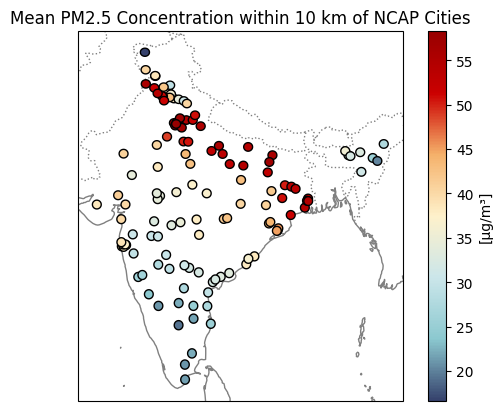

In [24]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(cfeature.BORDERS, linestyle=':', color='gray', zorder=0)
ax.add_feature(cfeature.COASTLINE, color='gray', zorder=1)

# da_total.plot(ax=ax, vmin=20, vmax=58, cmap=goodbad_cont)

p = df_plot.plot(column='mean_pm2.5_ug/m3', cmap=goodbad_cont, legend=True, markersize=10,
                     legend_kwds={'label': '[µg/m³]'}, ax=ax, edgecolor='black',
                    #   vmin=20, vmax=58,
                     ).set_title('Mean PM2.5 Concentration within 10 km of NCAP Cities')


/home/work/Documents/projects/202505_india_secondary_aerosol/202505_india_secondary_aerosol/.venv/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


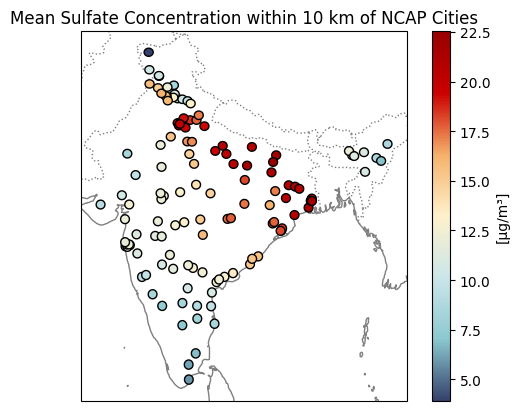

In [25]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(cfeature.BORDERS, linestyle=':', color='gray', zorder=0)
ax.add_feature(cfeature.COASTLINE, color='gray', zorder=1)

# da_sulfate.plot(ax=ax, vmin=6, vmax=22, cmap=goodbad_cont)

p = df_plot.plot(column='mean_ammonium_sulfate_ug/m3', cmap=goodbad_cont, legend=True, markersize=2,
                     legend_kwds={'label': '[µg/m³]'}, ax=ax, edgecolor='black',
                    #  vmin=6, vmax=22,
                     ).set_title('Mean Sulfate Concentration within 10 km of NCAP Cities')


/home/work/Documents/projects/202505_india_secondary_aerosol/202505_india_secondary_aerosol/.venv/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


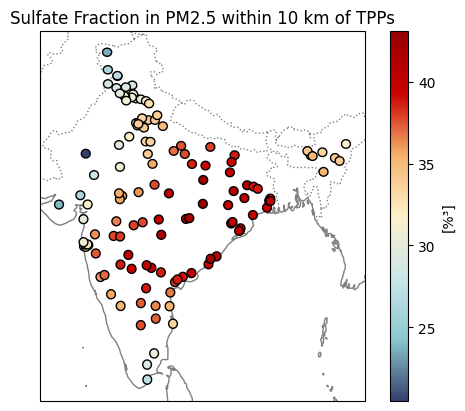

In [26]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(cfeature.BORDERS, linestyle=':', color='gray', zorder=0)
ax.add_feature(cfeature.COASTLINE, color='gray', zorder=1)

# da_fraction.plot(ax=ax, vmin=10, vmax=45, cmap=goodbad_cont)

p = df_plot.plot(column='sulfate_fraction_%', cmap=goodbad_cont, legend=True, markersize=2,
                     legend_kwds={'label': '[%³]'}, ax=ax, edgecolor='black',
                    #  vmin=10, vmax=45, 
                     ).set_title('Sulfate Fraction in PM2.5 within 10 km of TPPs')


Calculate distance from cities to closest power plant.

In [27]:
from pyproj import Geod
# Create a Geod object with WGS84 ellipsoid
geod = Geod(ellps="WGS84")

# Extract lat/lon as separate arrays
lats1, lons1 = df_ncap_buffered['Latitude'].values, df_ncap_buffered['Longitude'].values
lats2, lons2 = df_tpp['Latitude'].values, df_tpp['Longitude'].values

# Create a meshgrid of all combinations
lons1_grid, lons2_grid = np.meshgrid(lons1, lons2, indexing='ij')
lats1_grid, lats2_grid = np.meshgrid(lats1, lats2, indexing='ij')

# Vectorized geodesic distance calculation
az12, az21, distances = geod.inv(lons1_grid, lats1_grid, lons2_grid, lats2_grid)

distances_km = distances / 1000.0

# closest power plant for each NCAP city
closest_indices = np.argmin(distances_km, axis=1)
closest_distances = np.min(distances_km, axis=1)

# fill to dataframe
df_ncap_buffered['distance_to_closest_tpp_km'] = closest_distances
df_ncap_buffered['closest_tpp_sno'] = df_tpp['SNo'].values[closest_indices]

In [28]:
# save results to csv
df_results2 = df_ncap_buffered[['130 NCAP Cities', 'mean_ammonium_sulfate_ug/m3', 'mean_pm2.5_ug/m3', 'sulfate_fraction_%', 'distance_to_closest_tpp_km', 'closest_tpp_sno']]

df_results2.to_csv(os.path.join(output_dir, '3d_ncapcities_means.csv'), index=False)